# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
# from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
dir_path = '../'
print(os.listdir(dir_path))

['Assignment1_Habermans', 'Assignment11_TSVD', 'models', 'database.sqlite', 'Assignment5_LogisticRegression', 'Assignment4_NaiveBayes', 'CNN', 'Assignment2_AmazonFoodReviews', 'Assignment8_DT', 'Assignment3_kNN', 'Assignment6_SGD', 'Assignment22_SQL', 'Assignment20_Quora', 'Assignment7_SVM', 'Assignment9_RF', 'Assignment10_Clustering']


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect(dir_path+'database.sqlite')

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 
# 500000 data points you can change the number to any other number 
# based on your computing power

filtered_data = pd.read_sql_query(
            "SELECT * FROM Reviews WHERE Score < 3 LIMIT 50000"
            , con)
filtered_data = filtered_data.append(
            pd.read_sql_query(
            "SELECT * FROM Reviews WHERE Score > 3 LIMIT 50000"
            , con))
 

# Give reviews with Score>3 a positive rating(1), and reviews with a
# score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
1,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
2,13,B0009XLVG0,A327PCT23YH90,LT,1,1,0,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, 
                                      ascending=True, inplace=False,
                                      kind='quicksort', 
                                      na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName",
                                          "Time","Text"}, 
                                  keep='first', inplace=False)
final.shape

(83317, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

83.317

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(83315, 10)


1    45420
0    37895
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.
This stuff tasted so terrible that I had to spit it out before any more of the content permeated my poor mouth. Most people around me wouldn't take up the dare to try one because of the hamster-cage smell drifting out of the bag. The couple people who tried couldn't keep it down. Listen, it's very hard to change your lifestyle, and cookies are more than just food that's bad for you. Cookies make a person feel good, it's true. But if regular cookies have been removed from your menu, try to find something else. Anything else.
These rose buds from Catey13 are precious. They have a soft aroma and a pretty look to them. I plan to use them for small sachets in the bags I bought from catey13, and use rose-colored ribbon to adorn the bags. I'm so glad this seller. I

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.
This stuff tasted so terrible that I had to spit it out before any more of the content permeated my poor mouth. Most people around me wouldn't take up the dare to try one because of the hamster-cage smell drifting out of the bag. The couple people who tried couldn't keep it down. Listen, it's very hard to change your lifestyle, and cookies are more than just food that's bad for you. Cookies make a person feel good, it's true. But if regular cookies have been removed from your menu, try to find something else. Anything else.
These rose buds from Catey13 are precious. They have a soft aroma and a pretty look to them. I plan to use them for small sachets in the bags I bought from catey13, and use rose-colored ribbon to adorn the bags. I'm so glad this seller. I

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

These rose buds from Catey13 are precious. They have a soft aroma and a pretty look to them. I plan to use them for small sachets in the bags I bought from catey13, and use rose-colored ribbon to adorn the bags. I am so glad this seller. I bought several things from her and she gave me a refund on the combined shipping costs.


In [20]:
#remove words with numbers python: 
# https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

These rose buds from Catey13 are precious They have a soft aroma and a pretty look to them I plan to use them for small sachets in the bags I bought from catey13 and use rose colored ribbon to adorn the bags I am so glad this seller I bought several things from her and she gave me a refund on the combined shipping costs 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', \
                'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', \
                'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', \
                'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', \
                'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', \
                'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because',\
                'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', \
                'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', \
                'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', \
                'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', \
                'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've",\
                'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', \
                "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma',\
                'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",\
                'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents
from tqdm import tqdm
preprocessed_reviews = []
review_score = []
# tqdm is for printing the status bar
for sentence, score in tqdm(final[['Text', 'Score']].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() \
                        if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())
    review_score.append(score)

100%|██████████| 83315/83315 [00:26<00:00, 3119.36it/s]


In [24]:
preprocessed_reviews[1500]

'rose buds precious soft aroma pretty look plan use small sachets bags bought use rose colored ribbon adorn bags glad seller bought several things gave refund combined shipping costs'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
## Similartly you can do preprocessing for review summary also.
# Combining all the above stundents 
preprocessed_summary = []
for summary in tqdm(final['Summary'].values):
    summary = re.sub(r"http\S+", "", summary)
    summary = BeautifulSoup(summary, 'lxml').get_text()
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip()
    summary = re.sub('[^A-Za-z0-9]+', ' ', summary)   # adding 0-9 in the regex
    summary = ' '.join(e.lower() for e in summary.split()\
                       if e.lower() not in stopwords)
    preprocessed_summary.append(summary.strip())

100%|██████████| 83315/83315 [00:14<00:00, 5665.52it/s]


In [26]:
len(preprocessed_summary)

83315

In [27]:
preprocessed_text = [str(rev+' '+summ) for rev, summ in \
                     zip(preprocessed_reviews, preprocessed_summary)]
print(preprocessed_text[:5])

['one best children books ever written mini version book not portrayed one priced product sent email regarding bewilderment amazon got no response awesome book poor size', 'give five stars maurice sendak story one star printed edition book children older copy book familiar previous softcover version ordered granddaughters embarrassed give gift looks puny book size postcard think overpriced learned lesson not buying softcover children books next time get used copy story great softcover book disappointing', 'dogs loves chicken product china wont buying anymore hard find chicken products made usa one isnt bad good product wont take chances till know going china imports made china', 'dogs love saw pet store tag attached regarding made china satisfied safe dog lover delites', 'received containers previously opened seals opened top containers decent pieces liver grisley pieces lot powder bottom never buy liver treats amazon big rip review freeze dried liver treats dogs']


# [4] Featurization

## [4.1] BAG OF WORDS

In [28]:
#BoW
fullPath = dir_path+'models/TSVD/'+'bow_vectors.pickle'
useOldData = True
count_vect = CountVectorizer(ngram_range=(1,1), min_df=10,
                          max_features=5000) #in scikit-learn
count_vect.fit(preprocessed_text)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
if os.path.isfile(fullPath) and useOldData:
    print("Reading vectors from drive..")
    with open(fullPath, 'rb') as f:
        bow_vectors = pickle.load(f)
    
else:
    bow_vectors = count_vect.transform(preprocessed_text)
  
    # Save the vectors
    with open(fullPath,'wb') as f:
        pickle.dump(bow_vectors, f)

print("\nShape After Vectorization ")
print("Data shape ", bow_vectors.shape)
print("Unique words in training : ", bow_vectors.get_shape()[1])

some feature names  ['ability', 'able', 'absolute', 'absolutely', 'absorb', 'absorbed', 'acai', 'accept', 'acceptable', 'accepted']

Shape After Vectorization 
Data shape  (83315, 5000)
Unique words in training :  5000


## [4.2] Bi-Grams and n-Grams.

In [29]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation 
#http://scikit-learn.org/stable/modules/generated/
#sklearn.feature_extraction.text.CountVectorizer.html

count_vect_bi = CountVectorizer(ngram_range=(1,2), min_df=10, 
                                max_features=5000)
final_bigram_counts = count_vect_bi.fit_transform(preprocessed_text)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", 
                    final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (83315, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [28]:
fullPath = dir_path+'models/TSVD/'+'tfIdf_vectors.pickle'
useOldData=True
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,
                             max_features=5000)
tf_idf_vect.fit(preprocessed_text)
print("Some sample features(unique words in the training corpus)",
    tf_idf_vect.get_feature_names()[0:10])
print('='*50)
if os.path.isfile(fullPath) and useOldData:
    print("Reading vectors from drive..")
    with open(fullPath, 'rb') as f:
        tfIdf_vectors = pickle.load(f)
else:
    tfIdf_vectors = tf_idf_vect.transform(preprocessed_text)
  
    # Save the vectors
    with open(fullPath,'wb') as f:
        pickle.dump(tfIdf_vectors, f)


print("\nShapes After Vectorization ")
print("Data shape ", tfIdf_vectors.shape)
print("Unique words in training : ", tfIdf_vectors.get_shape()[1])

Some sample features(unique words in the training corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely loves', 'absolutely no']
Reading vectors from drive..

Shapes After Vectorization 
Data shape  (83315, 5000)
Unique words in training :  5000


## [4.4] Word2Vec

In [33]:
# Train your own Word2Vec model using your own text corpus
i=0

# whole sentences broken to sentences-wise tokens
sentence_tokens = [sentence.split() for sentence in preprocessed_text]

In [35]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need


is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True
fullPath = dir_path+'models/TSVD/'+'w2V_model.pickle'
useOldData=True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    if os.path.isfile(fullPath) and useOldData:
        with open(fullPath, 'rb') as f:
            w2v_model = pickle.load(f)
    else:
        print("Training..")
        w2v_model=Word2Vec(sentence_tokens,min_count=5,size=128, workers=4)
        # Save word2Vec model
        with open(fullPath,'wb') as f:
            pickle.dump(w2v_model, f)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format(
                      'GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep \
          want_to_train_w2v = True, to train your own w2v ")

Training..
[('fantastic', 0.7989708781242371), ('excellent', 0.7842246890068054), ('awesome', 0.7675524950027466), ('terrific', 0.7278028726577759), ('good', 0.7110978960990906), ('wonderful', 0.7095855474472046), ('amazing', 0.6469885110855103), ('nice', 0.6186779737472534), ('perfect', 0.6085929870605469), ('fabulous', 0.6003957986831665)]
[('nastiest', 0.771957278251648), ('weakest', 0.7321192026138306), ('foulest', 0.6771084666252136), ('disgusting', 0.6687463521957397), ('grossest', 0.6548816561698914), ('best', 0.6296494007110596), ('greatest', 0.6150306463241577), ('weirdest', 0.6107233762741089), ('vile', 0.5988492369651794), ('terrible', 0.5912120938301086)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  18141
sample words  ['one', 'best', 'children', 'books', 'ever', 'written', 'mini', 'version', 'book', 'not', 'portrayed', 'priced', 'product', 'sent', 'email', 'regarding', 'amazon', 'got', 'no', 'response', 'awesome', 'poor', 'size', 'give', 'five', 'stars', 'story', 'star', 'printed', 'edition', 'older', 'copy', 'familiar', 'previous', 'ordered', 'granddaughters', 'embarrassed', 'gift', 'looks', 'puny', 'think', 'overpriced', 'learned', 'lesson', 'buying', 'next', 'time', 'get', 'used', 'great']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [37]:
fullPath = dir_path+'models/TSVD/'+'avg_W2V.pickle'
useOldData=True

# average Word2Vec

avgW2V_vectors = []
c = 0

if os.path.isfile(fullPath) and useOldData:
    print("Vectors loaded from drive..")
    with open(fullPath, 'rb') as f:
        avgW2V_vectors = pickle.load(f)
    
else:
    for sent in sentence_tokens:
        c += 1
        if c % 1000==0:
            print("Progress : {:3d} %  ".format(
                    int(c/len(sentence_tokens)*100)),
                    end='\r')
        sent_vec = np.zeros(128)
        cnt_words = 0
        for word in sent:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        avgW2V_vectors.append(sent_vec)
  
    print("Saving to drive..")
    with open(fullPath,'wb') as f:
        pickle.dump(avgW2V_vectors, f)

print("Dims of Data : ({}, {})".format(len(avgW2V_vectors), 
                                        len(avgW2V_vectors[0])))

Saving to drive.. 
Dims of Data : (83315, 128)


#### [4.4.1.2] TFIDF weighted W2v

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(min_df=5)
tf_idf_matrix = model.fit_transform(preprocessed_text)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [40]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, 
# col=word and cell_val = tfidf

fullPath = dir_path+'models/TSVD/'+'tfIdf_avg_W2V.pickle'
useOldData=True

tfidf_avgW2V_vectors = []
c = 0

if os.path.isfile(fullPath) and useOldData:
    print("Vectors loaded from drive..")
    with open(fullPath, 'rb') as f:
        tfidf_avgW2V_vectors = pickle.load(f)
    
else:
    for sent in sentence_tokens:
        c += 1
        if c % 1000==0:
            print("Progress : {:3d} %  ".format(
                    int(c/len(sentence_tokens)*100)), 
                    end='\r')
        sent_vec = np.zeros(128)
        weight_sum = 0
        for word in sent:
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_avgW2V_vectors.append(sent_vec)
              
    print("Saving to drive..")
    with open(fullPath,'wb') as f:
        pickle.dump(tfidf_avgW2V_vectors, f)
    

print("Dims of Data : ({}, {})".format(len(tfidf_avgW2V_vectors), 
                                        len(tfidf_avgW2V_vectors[0])))

Saving to drive.. 
Dims of Data : (83315, 128)


# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [29]:
# Please write all the code with proper documentation
# taking top 2500 features
top_features = np.take(tf_idf_vect.get_feature_names(), 
    tf_idf_vect.idf_.argsort()[-1:-2501:-1])

### [5.2] Calulation of Co-occurrence matrix

In [30]:
from scipy.sparse import csr_matrix

In [31]:
# # Please write all the code with proper documentation
# co_occur_matrix = csr_matrix((len(top_features), len(top_features)),dtype=np.int32)
# word2Id = dict(zip(top_features, range(len(top_features))))

# # For this co-occurence matrix same context means a window of 3 words so the 
# # combination we will look for are : W1 W2, W1 someword W2, W2 W1, W2 someword W1

# # for word1 in top_features:
# #     for word2 in top_features:
# #         if word1 != word2:
# #             for sent in preprocessed_text:
# #                 id1=word2Id[word1]
# #                 id2=word2Id[word2]
# #                 count = len(re.findall('\\b'+word1+'\s+'+word2+'\\b'+
# #                         '|\\b'+word1+'\s+[a-zA-Z0-9]+\s+'+word2+'\\b', sent))
# #                 co_occur_matrix[id1, id2] += count
# #                 co_occur_matrix[id2, id1] += count
# # (2500*2500*83315)

# # The above code has much high run time complexity (loops) than the below code
# for sent in tqdm(preprocessed_text):
#     sent_tokens = sent.split()
#     if len(sent_tokens) >= 2:
#         t1,t2,t3 = 0,1,2
#         id1 = word2Id.get(sent_tokens[t1])
#         id2 = word2Id.get(sent_tokens[t2])
#         if id1 is not None and id2 is not None:
#             co_occur_matrix[id1, id2] += 1
#             co_occur_matrix[id2, id1] += 1
#         while (t3 < len(sent_tokens)):
#             id3 = word2Id.get(sent_tokens[t3])
#             if id1 is not None and id3 is not None:
#                 co_occur_matrix[id1, id3] += 1
#                 co_occur_matrix[id3, id1] += 1
#             if id2 is not None and id3 is not None:
#                 co_occur_matrix[id2, id3] += 1
#                 co_occur_matrix[id3, id2] += 1
#             t3+=1
#             id1=id2
#             id2=id3

In [34]:
## 

# 1. Could you please recheck your co-occurence matrix with the below corpus and top words. please consider 
# Courpus: "abc def ijk pqr", "pqr klm opq", "lmn pqr xyz abc def pqr abc"
# top_words: "abc", "pqr", "def"
# window_size: 2

# Please make sure that you get below matrix

# Co_occurace matrix
#      abc  pqr  def
# abc: 3    3    3
# pqr: 3    4    2
# def: 3    2    2

# For window size 2, the slice will be of 5 words
test_corpus = ["abc def ijk pqr", "pqr klm opq", "lmn pqr xyz abc def pqr abc"]
top_words = ["abc", "pqr", "def"]

In [35]:
# Lets create a generic function to return the co-occurrence matrix
def get_Co_Occurance_Matrix(text_corpus,top_features,winsize=2):
    co_occur_matrix = csr_matrix((len(top_features), len(top_features)),dtype=np.int32)
    word2Id = dict(zip(top_features, range(len(top_features))))
    
    for sent in tqdm(text_corpus):
        sent_tokens = sent.split()
        for i in range(len(sent_tokens)):
            window=range(i,min(i+winsize+1, len(sent_tokens)))
            w0=word2Id.get(sent_tokens[window[0]])
            for w in window:
                wi=word2Id.get(sent_tokens[w])
                if w0 is not None and wi is not None:
                    co_occur_matrix[w0,wi] += 1
                    if wi!=w0:
                        co_occur_matrix[wi,w0] += 1
    return co_occur_matrix

In [36]:
print(test_corpus)
print(top_words)
print(co_occur_mat_test.A)
print(word2Id_test)

['abc def ijk pqr', 'pqr klm opq', 'lmn pqr xyz abc def pqr abc']
['abc', 'pqr', 'def']
[[0 0 0]
 [0 0 0]
 [0 0 0]]
{'abc': 0, 'pqr': 1, 'def': 2}


In [37]:
print(get_Co_Occurance_Matrix(test_corpus,top_words,2).A)

100%|██████████| 3/3 [00:00<00:00, 306.51it/s]

[[3 3 3]
 [3 4 2]
 [3 2 2]]


In [39]:
co_occur_matrix = get_Co_Occurance_Matrix(preprocessed_text,top_features,winsize=2)

100%|██████████| 83315/83315 [01:20<00:00, 1037.69it/s]


### [5.3] Finding optimal value for number of components (n) to be retained.

In [40]:
# Please write all the code with proper documentation
from sklearn.decomposition import TruncatedSVD

100%|██████████| 2000/2000 [1:44:39<00:00,  9.67s/it]
No handles with labels found to put in legend.


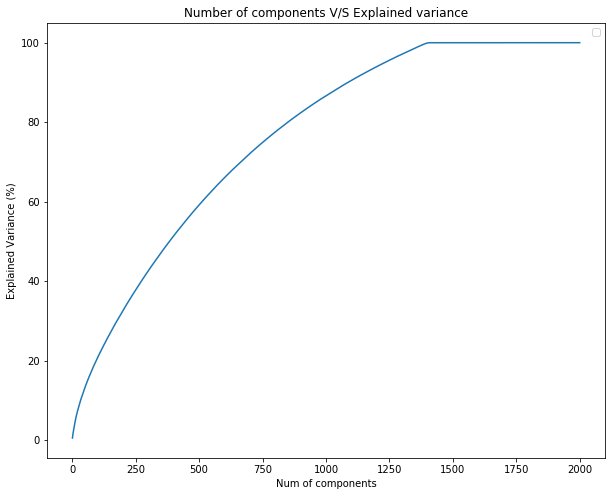

In [42]:
ncomponents = range(1,2001,1)
explained_var = []
for ncomp in tqdm(ncomponents):
    svd = TruncatedSVD(n_components=ncomp)
    svd.fit(co_occur_matrix)
    explained_var.append(round(svd.explained_variance_ratio_.sum()*100,2))
    
plt.figure(figsize=(10.0, 8.0))
plt.plot(ncomponents, explained_var)
plt.legend()
plt.xlabel('Num of components')
plt.ylabel("Explained Variance (%)")
plt.title("Number of components V/S Explained variance")
plt.show()

We see the explained variance close to 100% for 1400 components

### [5.4] Applying k-means clustering

In [43]:
svd = TruncatedSVD(n_components = 1400)
trunc_data = svd.fit_transform(co_occur_matrix)

In [44]:
# Please write all the code with proper documentation
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from collections import defaultdict
from wordcloud import WordCloud

In [45]:
def search_for_K(vectors):
    klist = list(range(1,21,2))
    sum_squared_dist = []
    for k in klist:
        kmeans = KMeans(n_clusters=k, random_state=1,n_jobs=4)
        kmeans = kmeans.fit(vectors)
        sum_squared_dist.append(kmeans.inertia_)
        print("Progress : {:3d} %  ".format(
                        int((k/20)*100)), end='\r')
        
    # Draw curve for elbow method
    plt.plot(klist, sum_squared_dist)
    plt.legend()
    plt.xlabel("No of clusters")
    plt.ylabel("Sum of Squared Distances")
    plt.title("k vs _inertia graph for KMeans")
    plt.show()

In [46]:
def label_vectors(vectors, num_of_clusters):
    kmeans = KMeans(n_clusters=num_of_clusters, random_state=1,
                    n_jobs=4)
    kmeans = kmeans.fit(vectors)
    labels = kmeans.predict(vectors)
    return labels

In [47]:
def get_clusterwise_words(features,vectors,labels,num_of_clusters):
    counters = {i:defaultdict(float) for i in range(num_of_clusters)}
    nzero_row, nzero_col = vectors.nonzero()
    for ri, ci in zip(nzero_row, nzero_col):
#         counters[labels[ri]].update([features[ci]]*vectors[ri,ci])
        counters[labels[ri]][features[ci]] += vectors[ri,ci]
#         print(ri, ci)
    return counters

No handles with labels found to put in legend.


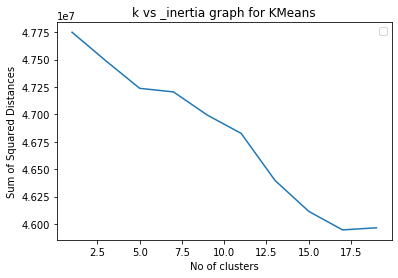

In [48]:
search_for_K(co_occur_matrix)

In [51]:
# by looking at the curve we decide optimal value of k=16
labels = label_vectors(co_occur_matrix, 16)

In [52]:
labels.shape

(2500,)

In [53]:
word_counters = get_clusterwise_words(top_features,co_occur_matrix, labels, 16)

### [5.5] Wordclouds of clusters obtained in the above section

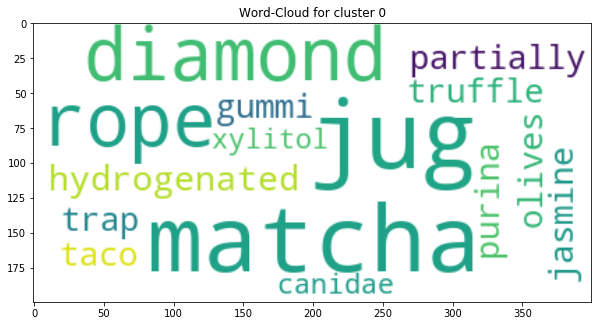

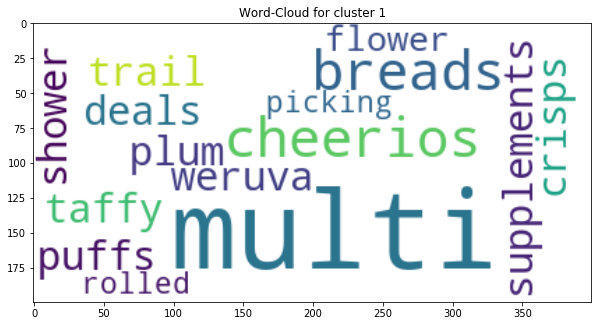

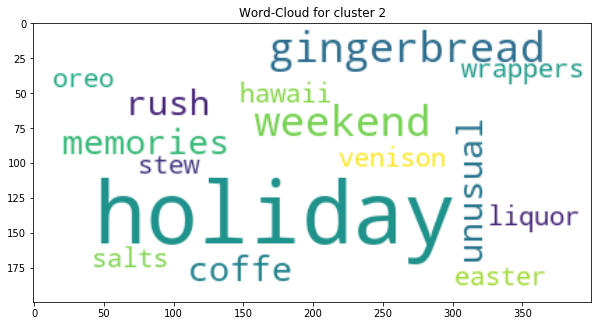

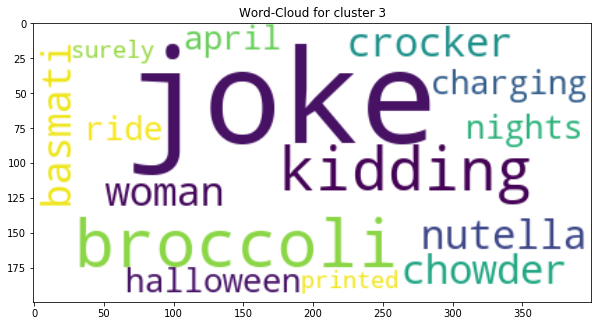

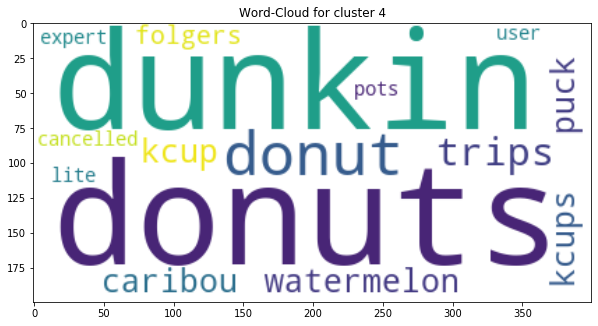

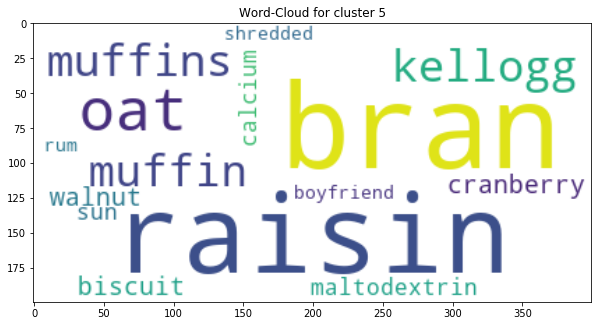

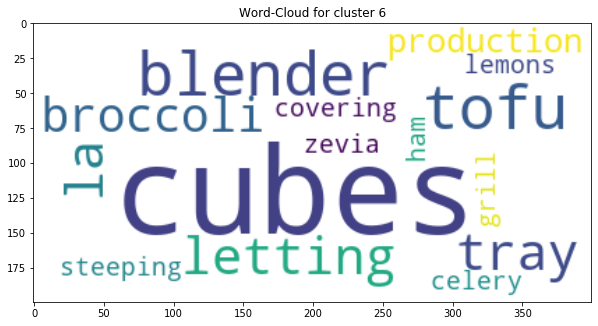

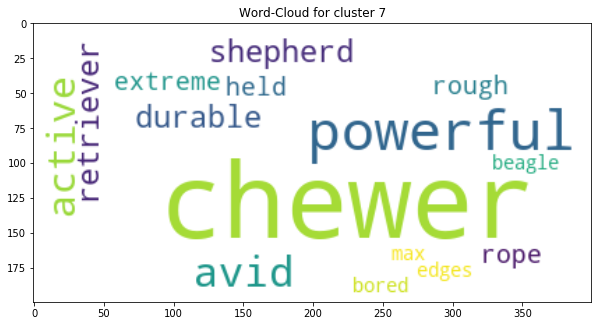

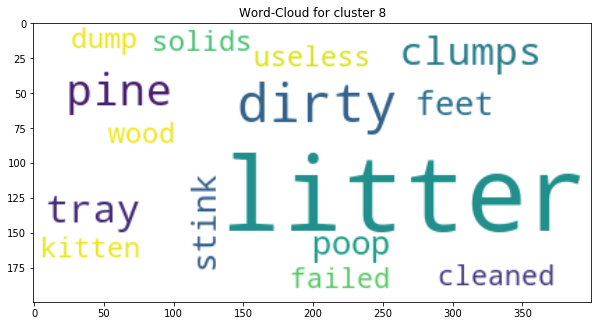

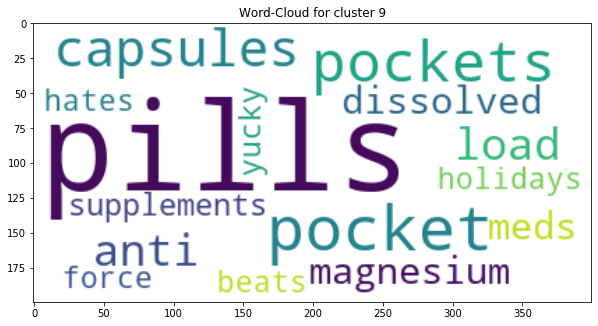

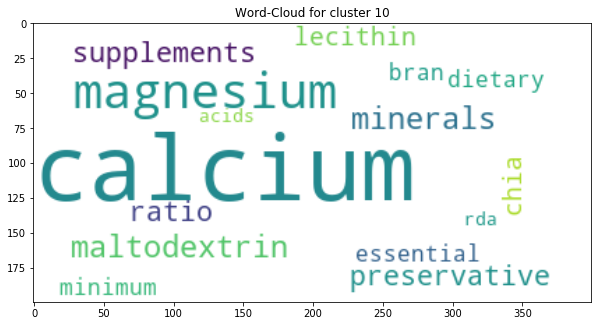

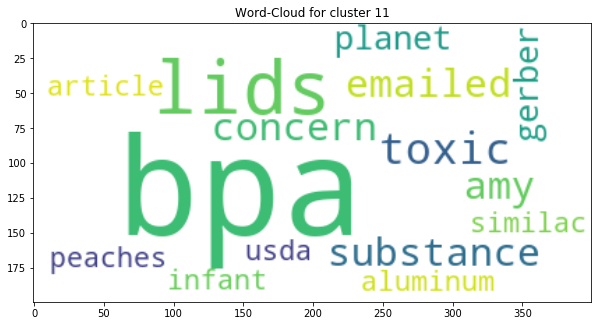

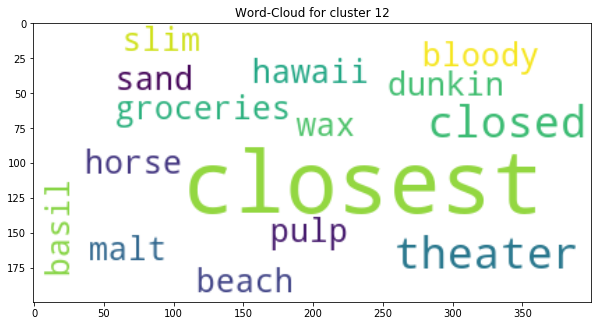

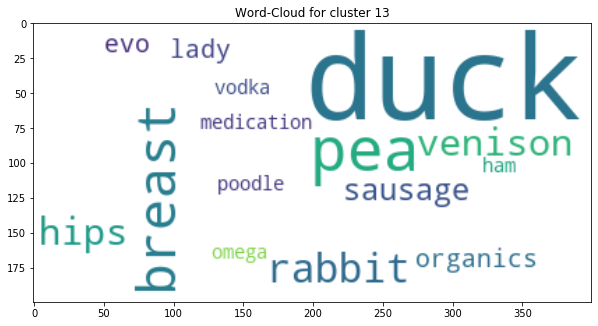

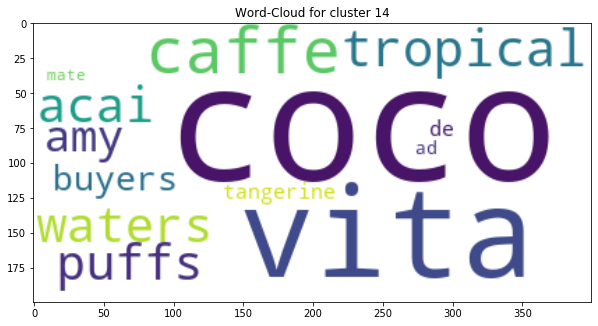

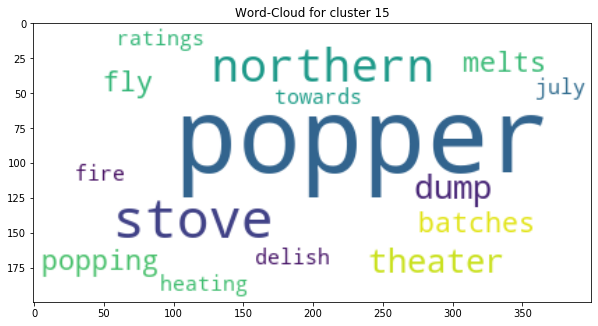

In [54]:
# Please write all the code with proper documentation
for c in word_counters.keys():
    # we will draw the word cloud for each cluster and we will
    # only consider top 15 words from each of the cluster
    wc = WordCloud(background_color="white",min_font_size=10).\
    generate_from_frequencies(dict(sorted(word_counters[c].items(), 
                    key=operator.itemgetter(1), reverse=True)[:15]))
    plt.figure(figsize=(10.0, 8.0))
    plt.title("Word-Cloud for cluster {}".format(c))
    plt.imshow(wc, interpolation='bilinear')

### [5.6] Function that returns most similar words for a given word.

In [55]:
# Please write all the code with proper documentation
from sklearn.metrics.pairwise import cosine_similarity

In [56]:
def get_similar_words(word, co_occur, top_features, nsims):
    # this gets pair-wise similarity
    similarity = cosine_similarity(co_occur)
    if len(np.where(top_features==word)[0]) == 0:
        print("Word '{}' not found. Retry.".format(word))
        return 
    # get most similar words based on co-occurrence 
    word_vect = similarity[np.where(top_features==word)[0][0]]
    index = word_vect.argsort()[-2:-(nsims+2):-1]
    similar_words = [top_features[i] for i in index]
    print("Words similar to '{}' are:".format(word))
    print(', '.join(similar_words))

In [57]:
get_similar_words(top_features[102], co_occur_matrix, top_features, 10)

Words similar to 'tape' are:
feet, measure, canister, covering, horse, reminiscent, additionally, worms, annoying, everytime


In [61]:
get_similar_words(top_features[10], co_occur_matrix, top_features, 10)

Words similar to 'preserves' are:
fig, rose, jam, ages, gentle, southern, sturdy, par, versatile, tad


In [67]:
get_similar_words(top_features[2499], co_occur_matrix, top_features, 10)

Words similar to 'add little' are:
waffle, claimed, tonight, wolfgang puck, pancake mix, retriever, one dogs, daughter loves, drink one, know would


In [69]:
get_similar_words(top_features[222], co_occur_matrix, top_features, 10)

Words similar to 'steeping' are:
overnight, proper, heating, teabags, adjust, appropriate, prompt, discover, medicinal, downside


# [6] Conclusions

In [0]:
# Please write down few lines about what you observed from this assignment. 
# Also please do mention the optimal values that you obtained for number of components & number of clusters.

    - We used truncated SVD method, using 2500 top features based on tf-Idf scores
    - Based on the amount of variance explained by tweaking with the number of components
        we finally settle on 1000 components and carry out experiments further
    - We further go for clustering on the co-occurrence matrix and by elbow method we 
        decide to keep the number of clusters as 13
    - Clustering looks good
    - We also were able to find the most similar words based on the cosine similarity 
        of the vectors in the co-occurrence matrix